# Variational Autoencoder (V)
This notebook trains the variational autoencoder (VAE) using data collected from 10K random rollouts

In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import pickle
from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras

In [12]:
tf.__version__

'2.0.0-alpha0'

## DATA

Load pickled data and review a random environment state

In [24]:
DATASET_DIR = '../src/dataset'

In [25]:
filenames = glob('{}/*'.format(DATASET_DIR))
len(filenames)

1583

In [15]:
rollout_data = pickle.load(open(filenames[0], 'rb'))

In [16]:
rollout_data[0][0].shape, len(rollout_data)

((96, 96, 3), 1000)

We first load 30% random files to train and test out autoencoder

In [26]:
# SAMPLE_SIZE = int(len(filenames)*0.03)
SAMPLE_SIZE = int(len(filenames)*0.003)

random_fnames = np.random.choice(filenames, SAMPLE_SIZE)
len(random_fnames)

4

Each rollout is saved as a pickled list of tuple(state, action, next_state). Let load the data and plot a random state.

In [27]:
dataset = [row[0] for fname in random_fnames for row in pickle.load(open(fname, 'rb'))]
len(dataset)

4000

In [28]:
dataset[0].shape, len(dataset)

((96, 96, 3), 4000)

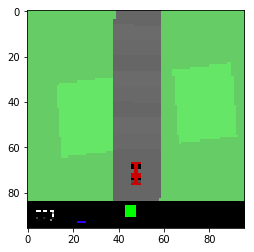

In [29]:
# plt.imshow(dataset[np.random.randint(0, len(dataset))])
plt.imshow(rollout_data[241][0])
plt.show()

# MODEL

Variational Autoencoder consists of encoder and decoder network just like vanilla autoencoder but instead of directly learning the latent vector $z$, the network learns the gaussian distribution mean and diagonal variance $(\mu, \sigma^2I)$

In [30]:
INPUT_SHAPE = (64,64,3)
LATENT_DIM = 32

### Encoder Network

We use conv layers for the encoder network

In [63]:
encoder_input = keras.Input(shape=(INPUT_SHAPE), name='encoder_input_image')
x = keras.layers.Conv2D(32, 4, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(64, 4, strides=(2,2), activation='relu')(x)
x = keras.layers.Conv2D(128, 4, strides=(2,2), activation='relu')(x)
x = keras.layers.Conv2D(256, 4, strides=(2,2), activation='relu')(x)
encoder_last_conv_shape = K.int_shape(x)[1:]
print("encoder_last_conv_shape: {}".format(encoder_last_conv_shape))
x = keras.layers.Flatten()(x)
mu = keras.layers.Dense(LATENT_DIM, activation='linear', name="mean")(x)
logvar = keras.layers.Dense(LATENT_DIM, activation='linear', name="variance")(x)

encoder = keras.Model(encoder_input, [mu, logvar], name='encoder')
encoder.summary()

encoder_last_conv_shape: (2, 2, 256)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_image (InputLayer [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 31, 31, 32)   1568        encoder_input_image[0][0]        
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 64)   32832       conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 6, 6, 128)    131200      conv2d_5[0][0]                   
_______________________________________________________

After the network has learned the gaussian params, we need a way to sample the latent vector. We do this by creating a Lambda layer that accepts mean and variance as input and sampled latent vector $z$ as output.

In [37]:
def sample(args):
    mean, logvar = args
    # reparameterizaton trick: allows gradients to pass through the sample
    # 1. sample from unit gaussian, then
    # 2. multiply it with standard deviation and add mean
    e = tf.random.normal(shape=(K.shape(mean)[0], LATENT_DIM))
    return e * tf.math.exp(logvar) + mean

In [38]:
sampled_latent_vector = keras.layers.Lambda(sample)([mu, logvar])

### Decoder Network
For Decoder network, we sample the latent vector $z$ from the gaussian distribution and use it as input for our decoder network which is make of Deconv layers

In [39]:
decoder_input = keras.layers.Input(shape=K.int_shape(sampled_latent_vector)[1:], name='decoder_input')
x = keras.layers.Dense(np.prod(encoder_last_conv_shape))(decoder_input)
x = keras.layers.Reshape((1,1,np.prod(encoder_last_conv_shape)))(x)
x = keras.layers.Conv2DTranspose(128, 5, strides=(2,2), activation='relu')(x)
x = keras.layers.Conv2DTranspose(64, 5, strides=(2,2), activation='relu')(x)
x = keras.layers.Conv2DTranspose(32, 6, strides=(2,2), activation='relu')(x)
decoder_output = keras.layers.Conv2DTranspose(3, 6, strides=(2,2))(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33792     
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 128)         3276928   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 64)        204864    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 30, 30, 32)        73760     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 3)         3459

### Loss

> VAEs train by maximising evidence lower bound (ELBO) on the marginal log-likelihood
$log\,p(x) >= \mathbb{E}_{q(z|x)} [ log \frac {p(x,z)} {q(z|x)}]$

>which is done by optimizing single sample Monte Carlo estimate of this expectation:
$ log\,p(x|z) + log\,p(z) - log\,q(z|x)$


Original: <a href="https://www.tensorflow.org/beta/tutorials/generative/cvae">source</a>


In [41]:
# Taken from tensorflow VAE example
def log_normal_pdf(sample, mean, var):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def calculate_loss(mean, logvar, labels, decoded_logits):
    xent_loss = tf.nn.softmax_cross_entropy_with_logits(labels, logits=decoded_logits)
    z = sample([mean, logvar])
    logpx_z = -tf.reduce_sum(xent_loss, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = pdf(z, mean, logvar)
    return -tf.reduce_mean(logp_z + logpz - logqz_x)

### VAE Model

And finally, we create a model that combines encoder and decoder to build the VAE

In [48]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, x):
        encoded = self.encoder(x)
        import pdb; pdb.set_trace()
        return encoded
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        return logits         

We then define the training step that performs the following operations on every batch
* take training data from batch and pass it through the encoder to approximate the parameters $(\mu \,,  \sigma^2)$ of posterior distribution
* sample latent variables from the posterior
* pass the samples to the decoder network to generated decoded logits
* calculate loss using decoded logits and training inputs
* compute and apply gradients

In [49]:
# Train step

# @tf.function
def train_step(train_x, model, optimizer):
    # use training inputs to approximate the posterior 
    mean, logvar = model.encode(train_x)
    # sample latent vector from the learned mean and variance
    latent_z = sample(mean, logvar)
    # decode z
    decoded_logits = model.decode(latent_z)
    # calculate loss    
    with tf.GradientTape() as tape:
        loss = calculate_loss(mean, logvar, labels=train_x, decoded_logits=decoded_logits)        
    # calculate gradients
    gradients = tape.gradients(loss, model.trainable_variables)
    # apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

Next, we load the numpy dataset using Dataset api from tf.data and define parameters such as batch size, buffer size to shuffle the data

In [65]:
train_ds = tf.data.Dataset.from_tensor_slices(dataset)

Our dataset generator script stored the ennvironment state as (state, action, next_state) tuple where the shape of state is (96,96,3). The encoder network expects the images to be of size (64,64,3) so we need to resize the images

W0829 12:24:20.609797 140170666792768 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 64, 64, 3)


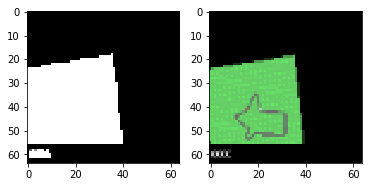

In [80]:
# Check the resize functionality
imgs=tf.image.resize(dataset[:2], [64, 64])
print(imgs.shape)
fig, ax = plt.subplots(1, 2)
# without normalisation
ax[0].imshow(imgs[0])
# Normalize to [0,1] range
ax[1].imshow(imgs[0]/255.0)
plt.show()

In [81]:
# Resize images
def preprocess_images(images):
    images = tf.image.resize(images, [64, 64])
    images = images/255.0
    return images

In [82]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_ds.map(preprocess_images, num_parallel_calls=AUTOTUNE)

In [87]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [88]:
# Inspect the image shape
for item in train_dataset:
    print(item.shape)
    break

(64, 64, 64, 3)


Now that we have all the ingredients in place, let's begin the training.
The following cell shows the main training loop.

In [89]:
# Number of training epochs
EPOCHS = 10
# Initialize the Variational Autoencoder model 
model = VAE(encoder, decoder)
# Define optimizer
optimizer = keras.optimizers.Adam(1e-4)

# keep track of losses
losses = []

# How often to print the loss
print_every = int(0.1 * EPOCHS)

for epoch in range(EPOCHS):
    for train_x in train_ds:
        loss = train_step(train_x, model, optimizer)
        losses.append(loss)
    if epoch % print_every == 0:
        print('Epoch {}/{}: train loss {}'.format(epoch, EPOCHS, losses[-1])) 

ValueError: Incompatible type conversion requested to type 'int32' for variable of type 'float32'

In [ ]:
def generate_sample_images(model):
    latent_z = tf.random.normal(shape=(4, LATENT_DIM))
    # decode z
    decoded = model.decode(latent_z, apply_sigmoid=True)
    print(decoder.shape)
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    for i, ax in enumerate(axs.flat):
        ax.imshow(decoder[i, :, :, 0])
        ax.axis('off')